# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


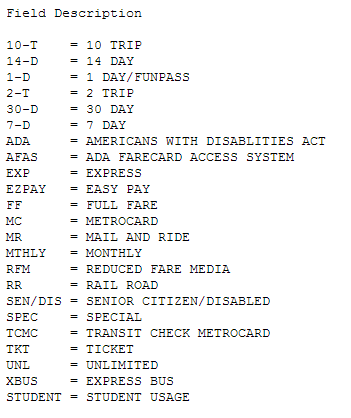

In [3]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [4]:
! curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy > MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  30.3M      0 --:--:-- --:--:-- --:--:-- 30.4M


In [316]:
mta = np.load('MTA_Fare.npy')

In [317]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [318]:
mta = mta.astype(float)
mta[mta==-1] = np.nan


create a "ride types" list based on the metadata I was given

In [311]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

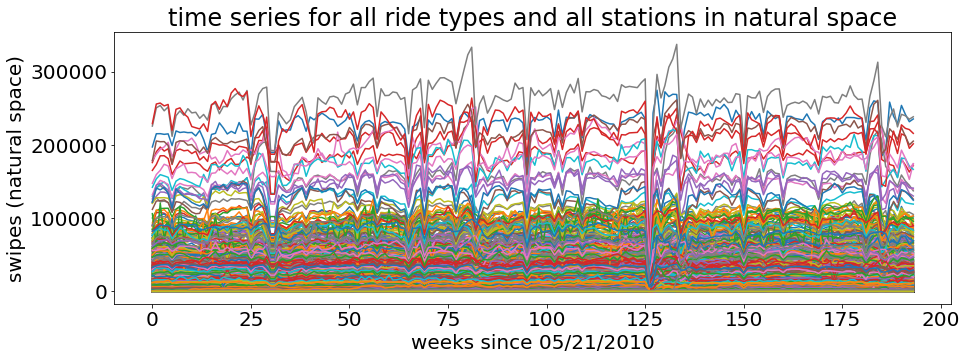

In [29]:
fig = plt.figure(figsize=(15, 5))
for i in range(0, len(mta)):
    for j in range(0,len(mta[i])):
        plt.plot(range(0,194), mta[i][j])

plt.xlabel("weeks since 05/21/2010")
plt.ylabel("swipes (natural space)")
plt.title("time series for all ride types and all stations in natural space")

# 
# plt.ylabel("swipes (natural space)")
# plt.title("time series for all ride types and all stations in natural space, \nweeks from 05/19/2010 to 02/19/2014")



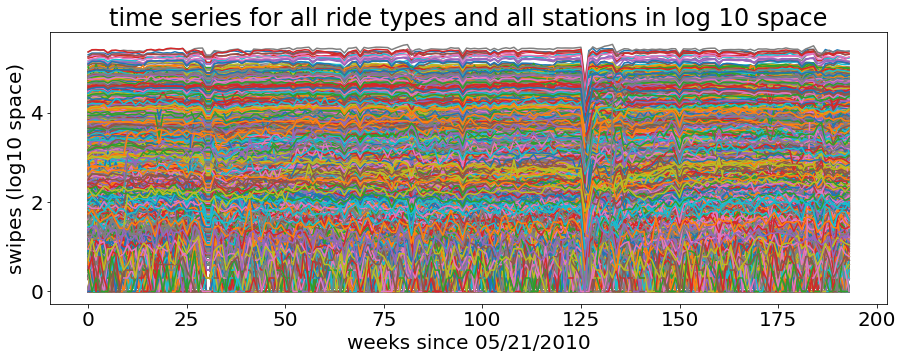

In [30]:
#plot the  data in log space
fig = plt.figure(figsize=(15, 5))
for i in range(0, len(mta)):
    for j in range(0,len(mta[i])):
        plt.plot(np.log10( mta[i][j]))
plt.xlabel("weeks since 05/21/2010")
plt.ylabel("swipes (log10 space)")
plt.title("time series for all ride types and all stations in log 10 space")



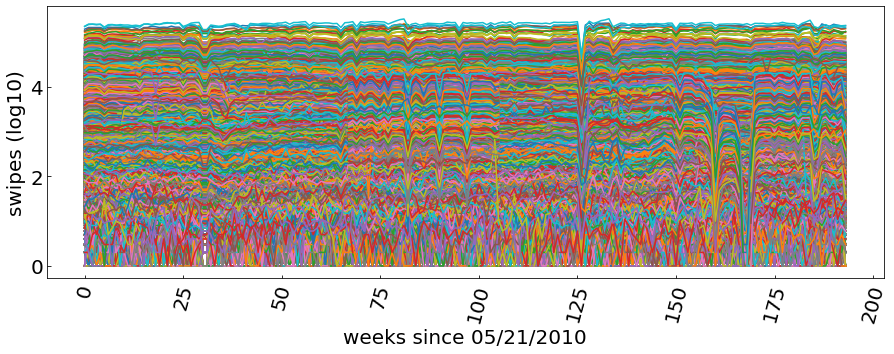

In [12]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)


#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [85]:
#collaps
mta_week_type = np.nansum(mta,axis=0)
mta_week = np.nansum(mta_week_type,axis=0)
mta_week.shape

(194,)

In [86]:
np.nanmean(mta_week)

29781349.87113402

In [87]:
np.nanstd(mta_week)

2983960.421700886

In [99]:
mean = mta_week.mean()
std = mta_week.std()
thresholds =[mean + 3*std, mean - 3*std]
print (thresholds)

[38733231.136236683, 20829468.606031362]


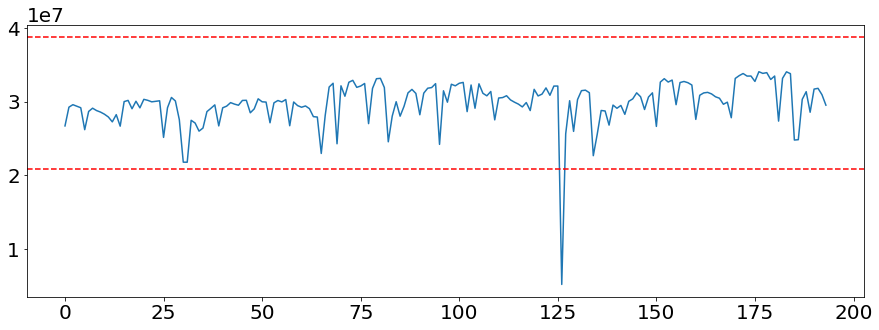

In [98]:
fig = plt.figure(figsize = (15,5))
plt.plot(mta_week)
plt.axhline(thresholds[0], ls = '--', c= 'r')
plt.axhline(thresholds[1], ls = '--', c= 'r')

In [120]:
mean = mta_week.mean()
std = mta_week.std()
thresholds =[mean + 3*std, mean - 3*std]
outlier = []
for i in range (len(mta_week)):
    if mta_week[i] < thresholds[1]:
        outlier.append(mta_week[i])
        week = i
print(outlier)
print(week)

[5218686.0]
126


In [126]:
weeks = pd.date_range('05/21/2010','02/21/2014',freq='W')

In [127]:
weeks[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

###### The mtarides droped significantly during the week from 2012-10-21 to 2012-10-28. 
##### I searched for news that could possiblly be the reason for this event. The first one is the natral disaster Hurricane Sandy. The following description was cited from WikiPedia:  
    "New York was severely affected by Hurricane Sandy in 2012, particularly New York City, its suburbs, and Long Island. Sandy's impacts included the flooding of the New York City Subway system, of many suburban communities, and of all road tunnels entering Manhattan except the Lincoln Tunnel. The New York Stock Exchange closed for two consecutive days. Numerous homes and businesses were destroyed by fire, including over 100 homes in Breezy Point, Queens. Large parts of the city and surrounding areas lost electricity for several days. Several thousand people in midtown Manhattan were evacuated for six days due to a crane collapse at Extell's One57."
###### The second reason may be the rise of fare happened during the week of Oct 22, 2012. However that was not a significant amount of increase. So I believe the reason for this significant drop was the Sandy.
    

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [172]:
mta_ctype = np.nansum(mta,axis=0)
# mta[0, :, 0]
len(mta_ctype[:,0])

23

In [202]:
df_ctype = pd.DataFrame(mta_ctype)
df_ctype.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,11494615.0,12526859.0,12766627.0,12653675.0,12809694.0,11429783.0,12346877.0,12576759.0,12437115.0,12431257.0,...,14604028.0,11344945.0,11223430.0,12864865.0,12904811.0,11932970.0,13139360.0,13189610.0,12500756.0,12459947.0
1,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0
2,47801.0,51486.0,51636.0,52063.0,51153.0,46852.0,48963.0,49629.0,49030.0,50376.0,...,62658.0,50820.0,45153.0,56129.0,60429.0,51664.0,57208.0,58771.0,56525.0,55192.0
3,186551.0,199229.0,199668.0,196389.0,194883.0,175648.0,188467.0,188090.0,186822.0,190528.0,...,193268.0,164607.0,148652.0,177885.0,193547.0,168932.0,189564.0,184239.0,180029.0,179363.0
4,46808.0,64353.0,56994.0,37429.0,35210.0,46849.0,60225.0,47439.0,32084.0,52171.0,...,56671.0,22623.0,25301.0,67713.0,64867.0,43426.0,47804.0,61101.0,59400.0,46859.0


In [192]:
rolling_ave = []
for i in range(23):
    a = df_ctype[i].rolling(10, center=True).mean()
    rolling_ave.append(a)
rolling_ave[5]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5     2500229.0
6     1360535.3
7     1326261.4
8     1321576.5
9     1315154.2
10    1383522.4
11    1022611.4
12     196678.0
13     195649.9
14     172351.5
15     120276.0
16     117607.2
17     106357.8
18     106357.5
19          NaN
20          NaN
21          NaN
22          NaN
Name: 5, dtype: float64

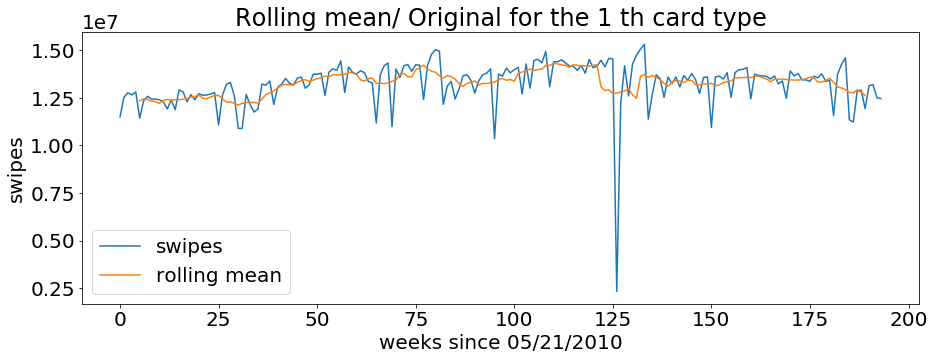

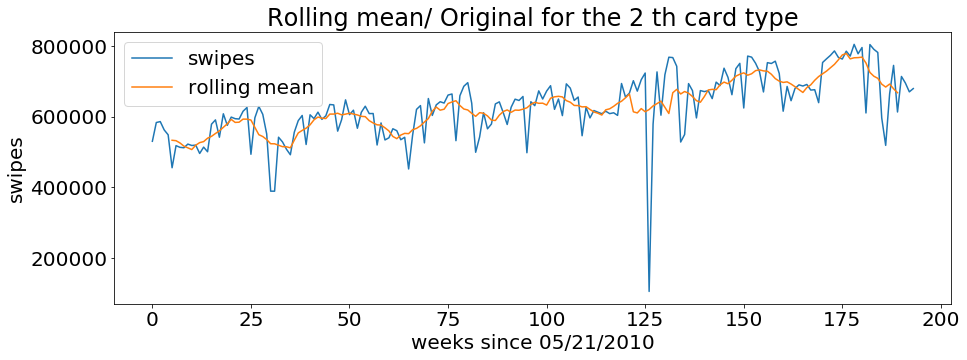

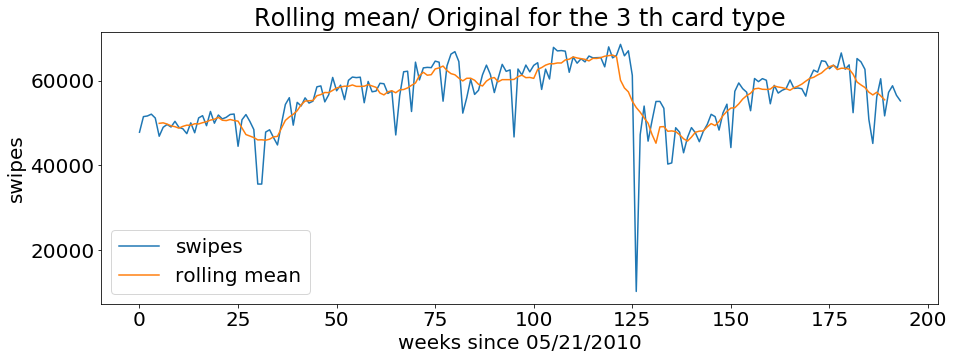

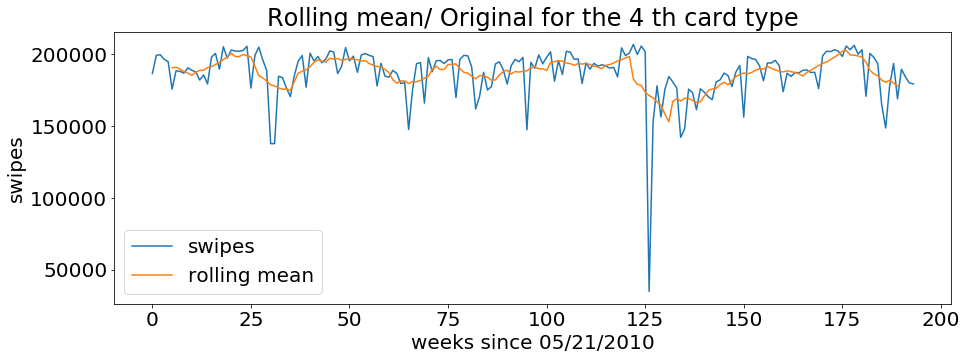

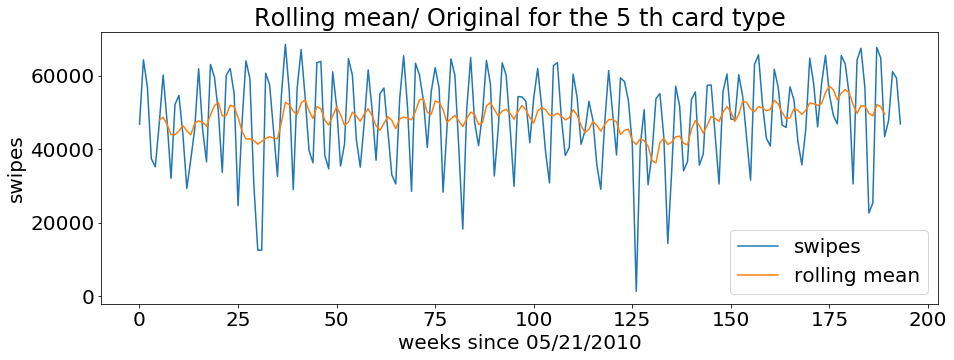

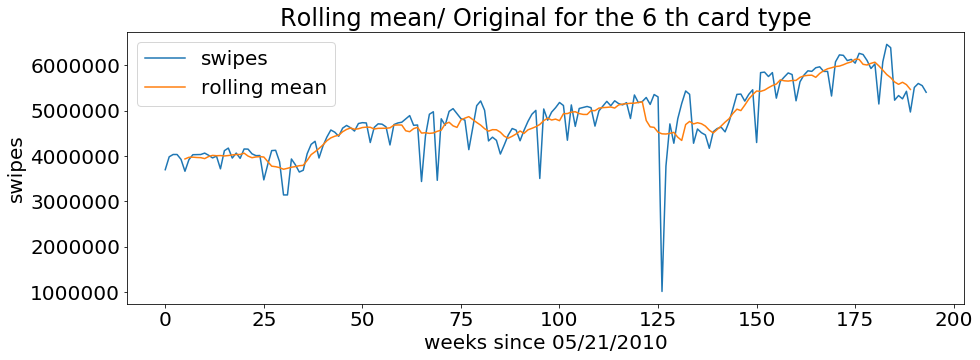

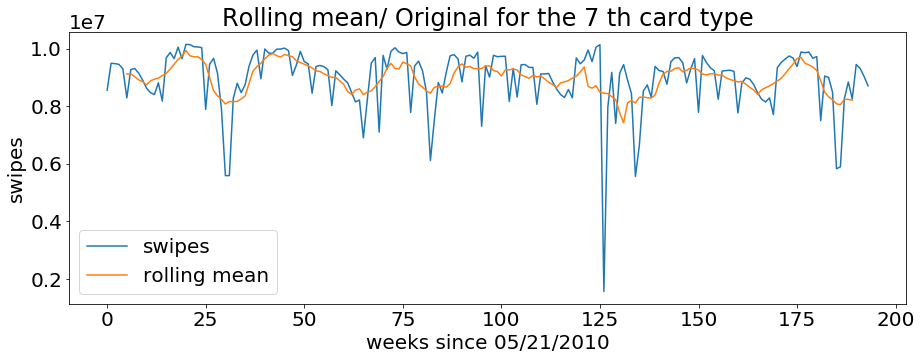

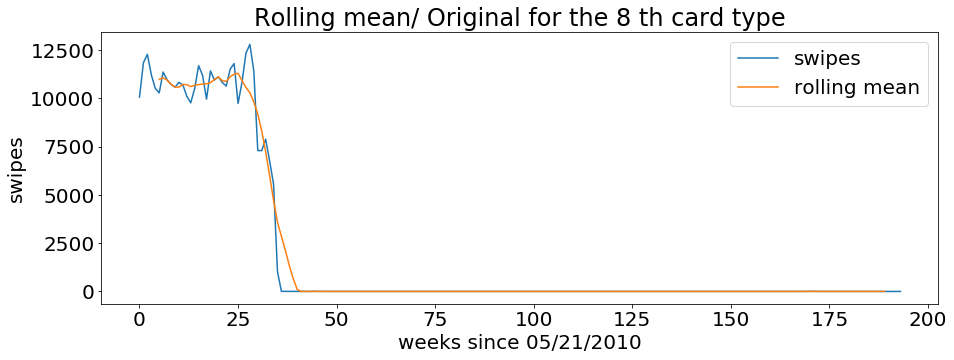

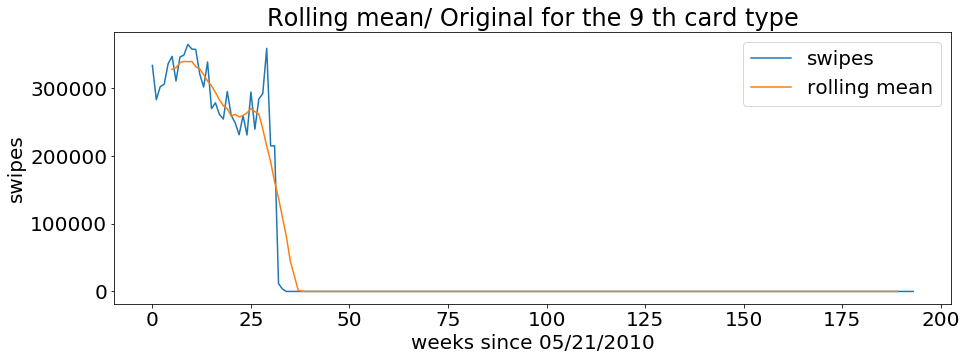

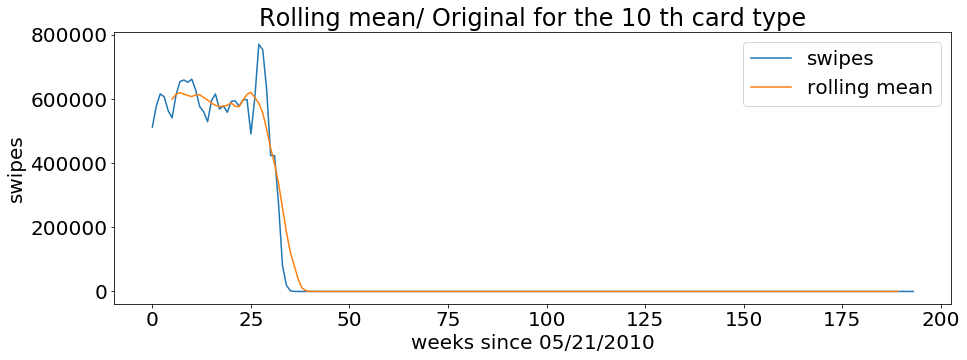

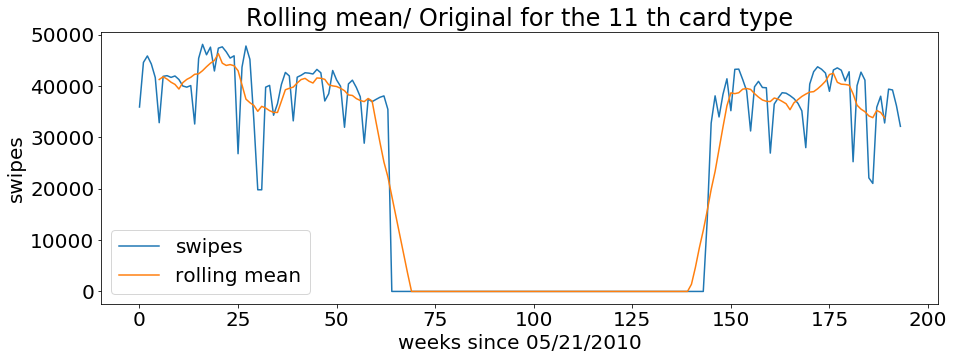

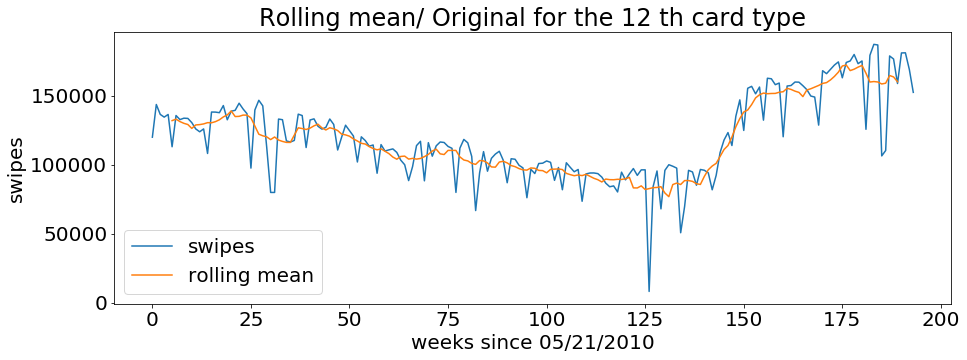

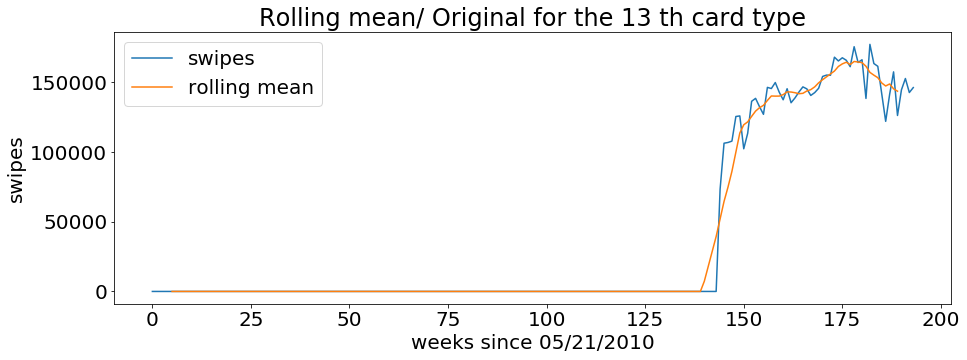

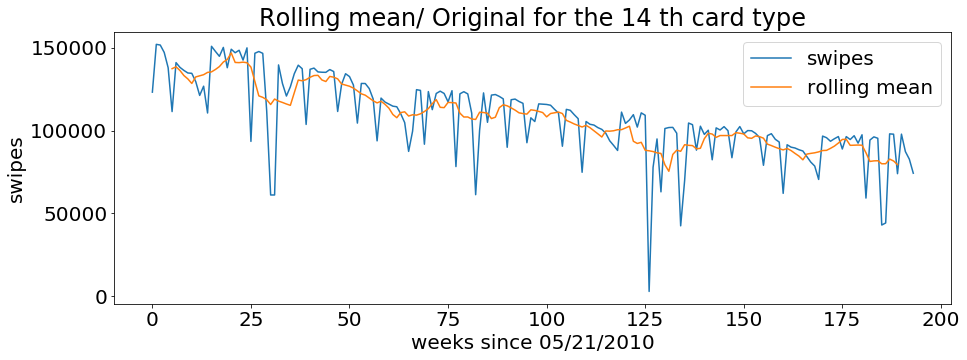

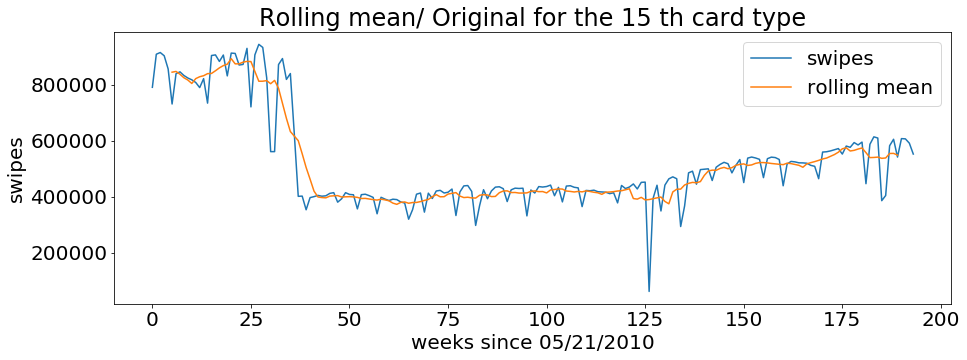

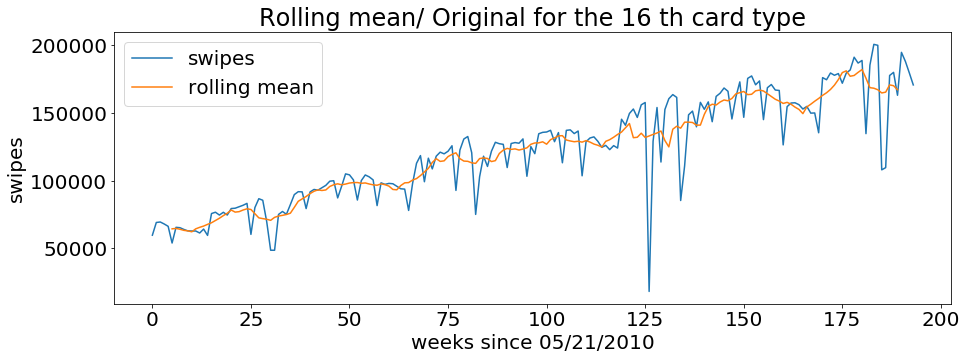

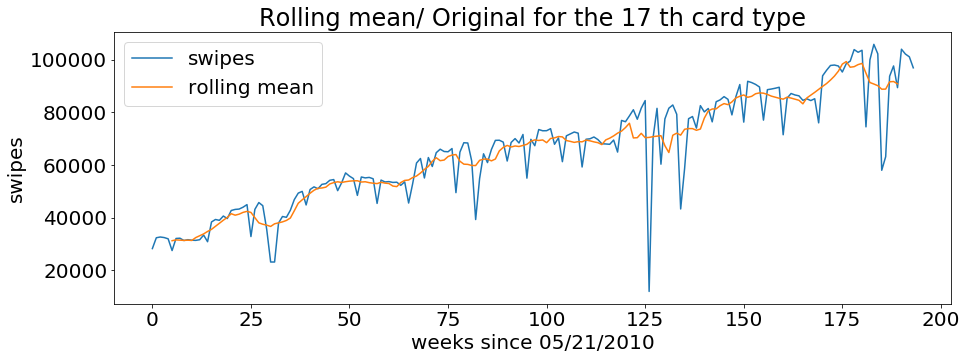

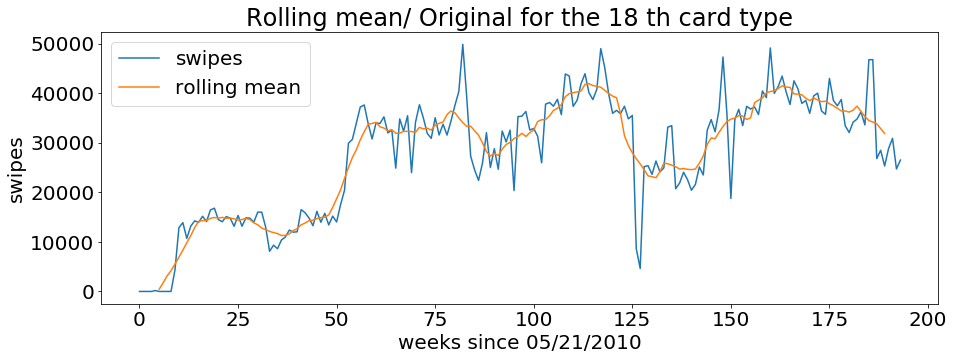

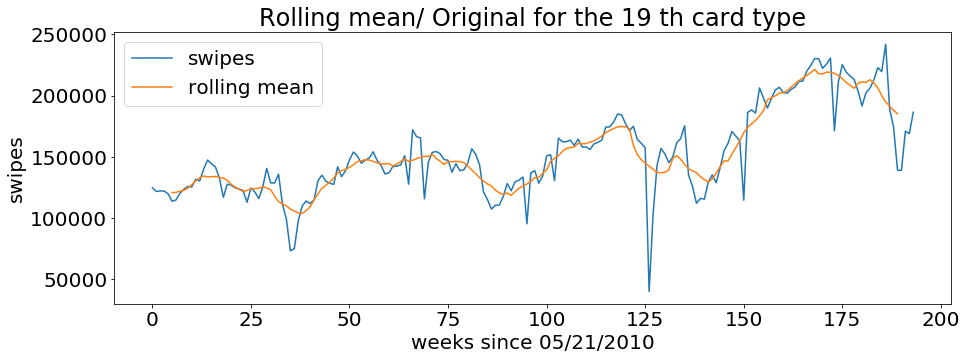

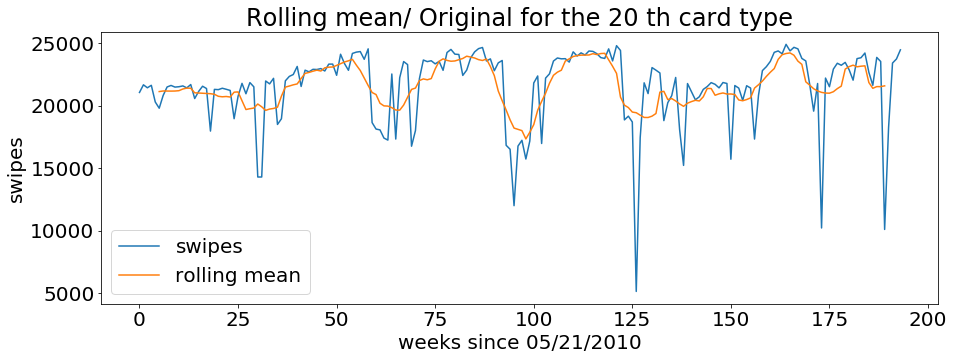

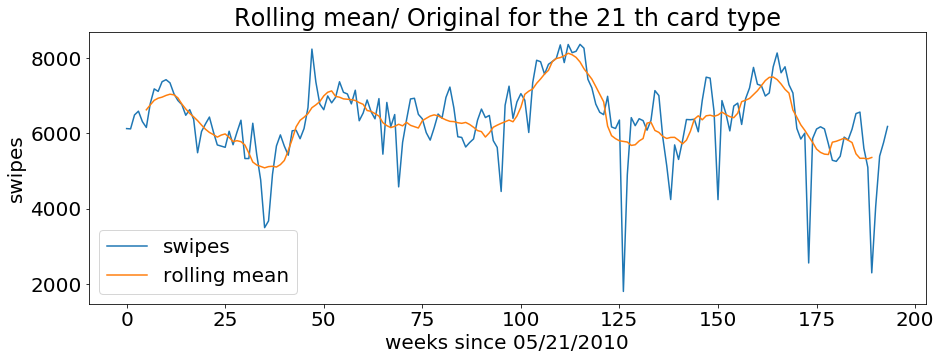

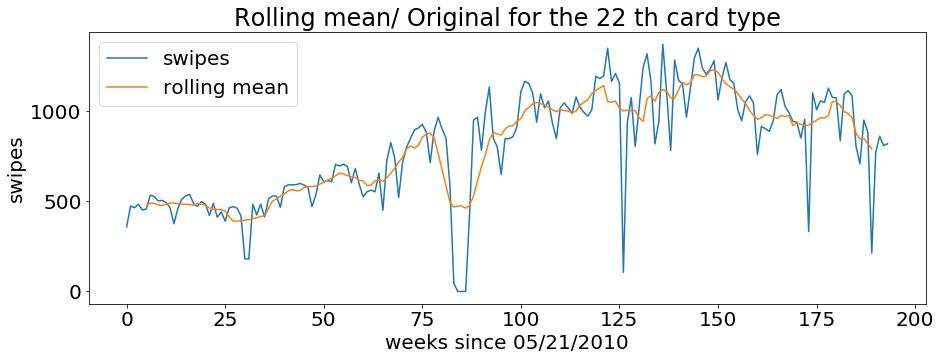

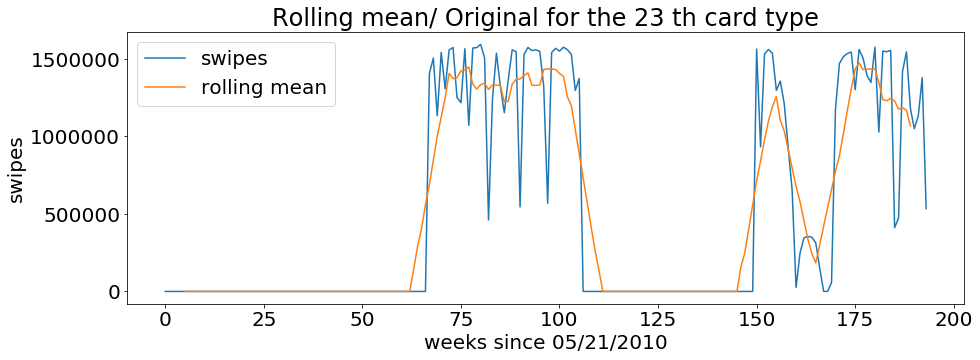

In [201]:
for i in range(23):
    fig = plt.figure(figsize=(15, 5))
    card_swipes_rmean = pd.DataFrame(mta_ctype[i]).rolling(10, center=True).mean()
    plt.plot(mta_ctype[i], label="swipes")
    plt.plot(card_swipes_rmean, label="rolling mean")
    plt.legend()
    plt.xlabel("weeks since 05/21/2010")
    plt.ylabel("swipes")
    plt.title("Rolling mean/ Original for the %s th card type"%(i + 1))

In [211]:
# Calculate the fractional ratio:
max_ratio = 0
max_index = 0
least_ratio = 1
least_index = 0
for i in range(len(mta_ctype[:,0])):
    stdev = nanstd(mta_ctype[i])
    ratio = mta_ctype[i][193]/mta_ctype[i][0]
    if ratio > max_ratio:
        max_ratio = ratio
        max_index = i
    if ratio < least_ratio:
        least_ratio = ratio
        least_index = i
    print("type number: %.0f" %i)
    print("Stdev: %.0f"%stdev)
    print("fractional change over time: %s"%ratio)
print("The steepest increase happened in the %sth card type"%max_index)
print("The steepest decrease happened in the %sth card type"%least_index)    

type number: 0
Stdev: 1212509
fractional change over time: 1.08398123817
type number: 1
Stdev: 90632
fractional change over time: 1.28080350748
type number: 2
Stdev: 7599
fractional change over time: 1.15462019623
type number: 3
Stdev: 17591
fractional change over time: 0.961468981673
type number: 4
Stdev: 12634
fractional change over time: 1.00108955734
type number: 5
Stdev: 763050
fractional change over time: 1.46184187288
type number: 6
Stdev: 1053450
fractional change over time: 1.01791559035
type number: 7
Stdev: 4062
fractional change over time: 0.0
type number: 8
Stdev: 110874
fractional change over time: 9.00368250615e-06
type number: 9
Stdev: 221304
fractional change over time: 1.95300293732e-06
type number: 10
Stdev: 19631
fractional change over time: 0.89525878879
type number: 11
Stdev: 29657
fractional change over time: 1.27094368582
type number: 12
Stdev: 63142
fractional change over time: 36588.25
type number: 13
Stdev: 23742
fractional change over time: 0.603180275147
ty

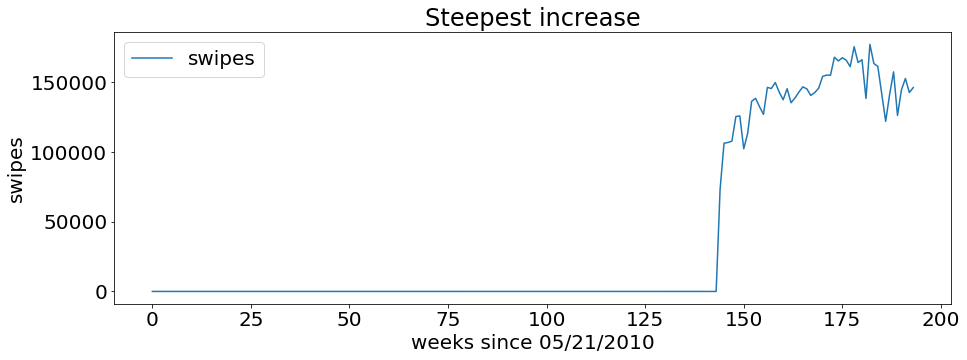

In [217]:
fig = plt.figure(figsize=(15, 5))
card_swipes_rmean = pd.DataFrame(mta_ctype[i]).rolling(10, center=True).mean()
plt.plot(mta_ctype[12], label="swipes")
plt.legend()
plt.xlabel("weeks since 05/21/2010")
plt.ylabel("swipes")
plt.title("Steepest increase")

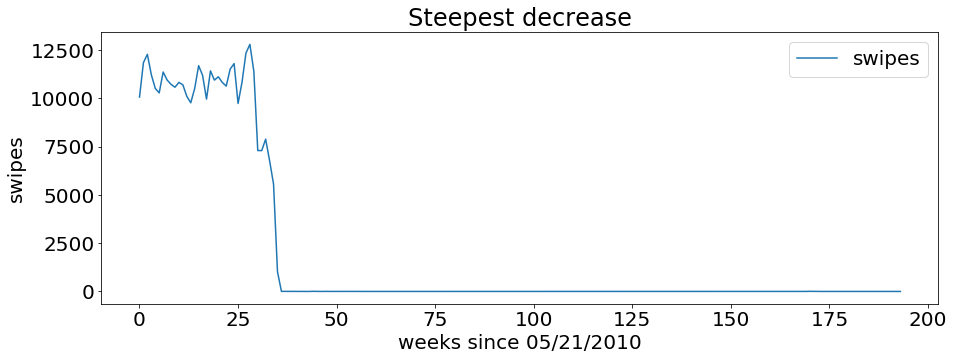

In [214]:
fig = plt.figure(figsize=(15, 5))
card_swipes_rmean = pd.DataFrame(mta_ctype[i]).rolling(10, center=True).mean()
plt.plot(mta_ctype[7], label="swipes")
plt.legend()
plt.xlabel("weeks since 05/21/2010")
plt.ylabel("swipes")
plt.title("Steepest decrease")

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [319]:
mta.shape

(600, 23, 194)

In [320]:
mta_reshape = pd.DataFrame(mta.reshape(600*23,194))
mta_reshape.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,43608.0,44774.0,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,1425.0,1085.0,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,217.0,189.0,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,576.0,460.0,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,290.0,109.0,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0


In [322]:
mta_reshape = mta_reshape.dropna(how='any').values
mta_reshape.shape

(9174, 194)

In [331]:
# Consulted with TianCheng Yin 
a = 9174 // 23
label = []
b = [x for x in range(0,23)]
for i in range(0, a):
    label.extend(b)
label.extend(b[:9174-a*23])
label = np.array(label)
label.shape

(9174,)

In [332]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [398]:
stationsmeans = []
for i in range (0, 600):
    stationsmeans.append(np.mean(mta[i].flatten()))
stationsmeans = np.array(stationsmeans)
stationsmeans.shape

(600,)

In [400]:
stationsstd = []
for i in range (0, 600):
    stationsstd.append(np.std(mta[i].flatten()))
stationsstd = np.array(stationsstd)
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [385]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  2,   2,   2, ..., 550, 550, 550])

In [386]:
tots = mta_reshape
tots.shape

(9174, 194)

In [387]:
tots_df = pd.DataFrame(tots)
norm_mean = []
norm_std = []
for i in range(0, 9174):
    norm_mean.append(tots_df.iloc[i].mean() / stationsmeans[i // 23])
    norm_std.append(tots_df.iloc[i].std() / stationsstd[i // 23])

In [396]:
stationsmeans[0]

nan

In [389]:
normed_time_series_mean = norm_mean
normed_time_series_std = norm_std

In [390]:
normed_time_series_std[:10]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [391]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



(9174,)

In [392]:
tsmean[:10]

array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
         3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
         1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
         3.00618557e+01])

In [394]:

tsstdev = np.nanstd(tots, axis=1)
tsstdev[:10]


array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
          4.23530701,  286.20893188,  182.35136007,    1.22685827,
         11.1163663 ,   67.14683317])

Text(0, 0.5, 'standardized number of rides')

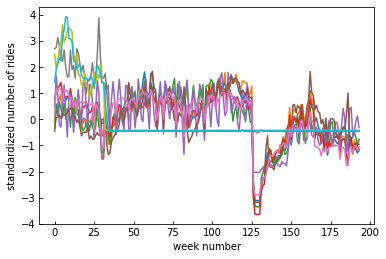

In [25]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [34]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

[71890.84869151471,
 2091.2375892149093,
 282.7639968279143,
 915.9172085646317,
 407.4856463124503,
 21297.24948453608,
 41997.96748612212,
 29.473909595559086,
 3439.0558287073763,
 1505.7963521015074]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

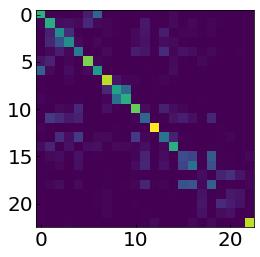

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

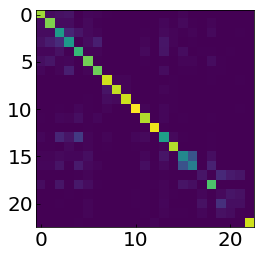

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   